In [2]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt
import zipfile


In [3]:

zf = zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/weid/data/data.zip') 
df = pd.read_csv(zf.open('data/train.csv'))
df.rename(columns={'itemId':'movieId'} , inplace=True)

In [4]:
user_ids = df["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
movie_ids = df["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
df["user"] = df["userId"].map(user2user_encoded)
df["movie"] = df["movieId"].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
df["rating"] = df["rating"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
min_rating = min(df["rating"])
max_rating = max(df["rating"])

print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating
    )
)

Number of users: 54754, Number of Movies: 55093, Min rating: 1.0, Max rating: 5.0


In [5]:
df = df.sample(frac=1, random_state=42)
x = df[["user", "movie"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
# Assuming training on 90% of the data and validating on 10%.
train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

In [6]:
EMBEDDING_SIZE = 50


class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super().__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)


model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
)

In [7]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=5,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/5
121108/121108 [==============================] - 614s 5ms/step - loss: 0.7557 - val_loss: 0.8634
Epoch 2/5
121108/121108 [==============================] - 607s 5ms/step - loss: 0.9458 - val_loss: 1.0139
Epoch 3/5
121108/121108 [==============================] - 610s 5ms/step - loss: 1.0609 - val_loss: 1.0889
Epoch 4/5
121108/121108 [==============================] - 615s 5ms/step - loss: 1.1268 - val_loss: 1.1384
Epoch 5/5
121108/121108 [==============================] - 602s 5ms/step - loss: 1.1679 - val_loss: 1.1728


In [8]:
model.save('/content/drive/MyDrive/Colab Notebooks/weid/data/')

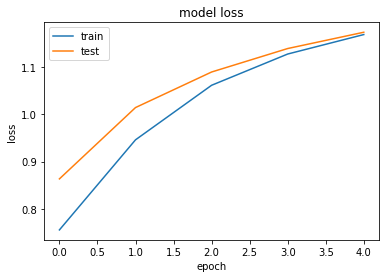

In [9]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [45]:
dftest = pd.read_csv(zf.open('data/test.csv'))
dftest.rename(columns={'itemId':'movieId'} , inplace=True)
dftest['user']=dftest['userId'].apply(lambda x: user2user_encoded.get(x))
dftest['movie']=dftest['movieId'].apply(lambda x: movie2movie_encoded.get(x))

In [48]:
dftest

,userId,movieId,date,user,movie
0,cgexjc,857869,2021-08-18 00:40:19,0,559
1,cgexjc,631765,2021-08-18 01:31:23,0,1583
2,cgexjc,232633,2021-08-18 01:12:46,0,2190
3,cgexjc,259982,2021-08-18 00:50:49,0,1584
4,cgexjc,131945,2021-08-18 00:56:13,0,1232
...,...,...,...,...,...
131353,yzesmd,388934,2021-07-30 08:48:06,54748,2008
131354,yzesmd,571188,2021-07-30 08:49:17,54748,12657
131355,yzesmd,707682,2021-07-30 08:49:40,54748,14747
131356,yzesmd,44761,2021-07-30 08:48:55,54748,4455


In [52]:
x_predict=dftest.iloc[:,3:5].values


array([[    0,   559],
       [    0,  1583],
       [    0,  2190],
       ...,
       [54748, 14747],
       [54748,  4455],
       [54748,  6645]])

In [53]:

newrating= model.predict(x_predict)

4105/4105 [==============================] - 11s 3ms/step


In [54]:
newrating

array([[0.99166566],
       [0.99133974],
       [0.9857739 ],
       ...,
       [0.12057137],
       [0.07316918],
       [0.18441653]], dtype=float32)